In [379]:
# ===============================================================
# 📘 修正版：指定コース×頭数データに基づく特徴量生成版
# ===============================================================

import numpy as np
import pandas as pd
import xgboost as xgb
from scipy import stats
import japanize_matplotlib

# ===============================================================
# 関数定義
# ===============================================================
def confidence_interval(mean: float, std: float, n: int, confidence: float = 0.95):
    t_value = stats.t.ppf((1 + confidence) / 2, df=n-1)
    margin = t_value * std / np.sqrt(n)
    return mean - margin, mean + margin

def handle_missing_val(df, features, enabled, min_horses):
    if not enabled:
        print("⚠ 欠損処理スキップ")
        return df

    print("欠損処理中...")
    processed_groups = []
    for race_id, group in df.groupby("race_id"):
        non_missing_mask = group[features].notnull().all(axis=1)
        if non_missing_mask.sum() < min_horses:
            continue
        for col in features:
            if group[col].isnull().any():
                group[col] = group[col].fillna(group[col].mean(skipna=True))
        processed_groups.append(group)
    df_processed = pd.concat(processed_groups, ignore_index=True)
    print(f"✅ 処理後: {len(df_processed)}件（元:{len(df)}）")
    return df_processed

def get_last_corner_position(row):
    for i in [4, 3, 2, 1]:
        val = row.get(f"position_{i}")
        if pd.notnull(val):
            return val
    return np.nan

# ===============================================================
# データ読み込み
# ===============================================================
num_horses = 12
target_course_id = 1400
input_file = "input_全頭_編集後.csv"

df = pd.read_csv(input_file, encoding="utf-8")
df["race_date"] = pd.to_datetime(df["race_date"])
print(f"全データ: {len(df)}件")

# 指定頭数のみに絞る
df = df[df["num_horses"] == num_horses].copy()
print(f"{num_horses}頭立て: {len(df)}件")

# 並び替え
df = df.sort_values(["race_id", "horse_number"])

# ===============================================================
# 欠損値処理
# ===============================================================
handle_missing = True
min_non_missing_horses = num_horses
missing_check_features = ["time_index_average_2", "jockey_place_rate_100"]

df_handle_missing_val = handle_missing_val(df, features=missing_check_features,
                                           enabled=handle_missing,
                                           min_horses=min_non_missing_horses)

# ===============================================================
# ランニングスタイル判定（全期間・全コースで算出）
# ===============================================================
style_stat_start_year = 2021
style_stat_end_year = 2024

df_style_period = df[
    (df["race_date"].dt.year >= style_stat_start_year) &
    (df["race_date"].dt.year <= style_stat_end_year)
].copy()

df_style_period["last_corner_position"] = df_style_period.apply(get_last_corner_position, axis=1)
df_style_period["last_corner_position_rate"] = (
    df_style_period["last_corner_position"] / df_style_period["num_horses"]
)

avg_corner_pos_rate = (
    df_style_period.groupby("horse_id")["last_corner_position_rate"]
    .mean()
    .reset_index()
    .rename(columns={"last_corner_position_rate": "avg_last_corner_pos_rate"})
)
avg_corner_pos_rate["running_style_type"] = np.where(
    avg_corner_pos_rate["avg_last_corner_pos_rate"] < 0.5, "front", "back"
)

# ===============================================================
# 分析対象データ（指定コース×頭数）
# ===============================================================
df_target = df_handle_missing_val[df_handle_missing_val["course_id"] == target_course_id].copy()
df_target = df_target.merge(avg_corner_pos_rate[["horse_id", "running_style_type"]],
                            on="horse_id", how="left")

# ===============================================================
# 特徴量作成
# ===============================================================

# (1) タイム指数平均との差
race_avg_time_index = df_target.groupby("race_id")["time_index_average_2"].transform("mean")
df_target["time_index_diff_from_avg"] = df_target["time_index_average_2"] - race_avg_time_index

# (2) 騎手勝率平均との差
race_avg_jockey_place_rate = df_target.groupby("race_id")["jockey_place_rate_100"].transform("mean")
df_target["jockey_place_rate_diff_from_avg"] = (
    df_target["jockey_place_rate_100"] - race_avg_jockey_place_rate
)

# (3) 馬番別勝率（指定コース×頭数）
df_target["is_win"] = (df_target["finish_rank"] == 1).astype(int)
win_rate_by_course_horse_number = (
    df_target.groupby(["course_id", "horse_number"])["is_win"]
    .mean()
    .reset_index()
    .rename(columns={"is_win": "win_rate_by_course_horse_number"})
)
df_target = df_target.merge(win_rate_by_course_horse_number,
                            on=["course_id", "horse_number"], how="left")

# (4) ランニングスタイル別勝率（指定コース×頭数）
course_style_win_prob = (
    df_target.groupby(["course_id", "running_style_type"])["is_win"]
    .mean()
    .reset_index()
    .rename(columns={"is_win": "running_style_win_prob"})
)
df_target = df_target.merge(course_style_win_prob,
                            on=["course_id", "running_style_type"], how="left")

# (5) 前方／後方全体勝率（指定コース×頭数）
style_stats = (
    df_target.groupby("running_style_type")
    .agg(total_horses=("horse_id", "count"),
         total_wins=("is_win", "sum"))
    .reset_index()
)
style_stats["style_win_prob"] = style_stats["total_wins"] / style_stats["total_horses"]
style_win_dict = style_stats.set_index("running_style_type")["style_win_prob"].to_dict()
df_target["style_win_prob_by_ratio"] = df_target["running_style_type"].map(style_win_dict)

# ===============================================================
# 相互作用項
# ===============================================================
df_target["time_index_diff_from_avg_and_jockey_place_rate_diff_from_avg"] = (
    df_target["time_index_diff_from_avg"] * df_target["jockey_place_rate_diff_from_avg"]
)
df_target["time_index_diff_from_avg_and_win_rate_by_course_horse_number"] = (
    df_target["time_index_diff_from_avg"] * df_target["win_rate_by_course_horse_number"]
)
df_target["jockey_place_rate_diff_from_avg_and_win_rate_by_course_horse_number"] = (
    df_target["jockey_place_rate_diff_from_avg"] * df_target["win_rate_by_course_horse_number"]
)

全データ: 634887件
12頭立て: 151128件
欠損処理中...
✅ 処理後: 80496件（元:151128）


In [383]:
# ===============================================================
# 特徴量リスト
# ===============================================================
features = [
    "time_index_diff_from_avg",
    "jockey_place_rate_diff_from_avg",
    "win_rate_by_course_horse_number",
    "time_index_diff_from_avg_and_jockey_place_rate_diff_from_avg",
    "time_index_diff_from_avg_and_win_rate_by_course_horse_number",
    "jockey_place_rate_diff_from_avg_and_win_rate_by_course_horse_number",
    "running_style_win_prob",
    "style_win_prob_by_ratio",
]

# ===============================================================
# ラベル作成
# ===============================================================
df_target["is_top4"] = (
    df_target.groupby("race_id")["finish_rank"]
    .rank(method="first") <= df_target["num_horses"] / 2
).astype(int)

# ===============================================================
# 学習用フィルタ
# ===============================================================
train_year = 2023
valid_year = 2024
filtered_df = df_target[
    (df_target["race_date"].dt.year >= train_year) &
    (df_target["race_date"].dt.year <= valid_year)
].copy()

print(f"filtered_df: {len(filtered_df)}件（course={target_course_id}, num_horses={num_horses}）")

# ===============================================================
# XGBoost モデル
# ===============================================================
df_m1 = filtered_df.copy()
X_m1 = df_m1[features]
y_m1 = df_m1["is_top4"]

X_train_m1 = X_m1[df_m1["race_date"].dt.year == train_year]
y_train_m1 = y_m1[df_m1["race_date"].dt.year == train_year]
X_val_m1   = X_m1[df_m1["race_date"].dt.year == valid_year]
y_val_m1   = y_m1[df_m1["race_date"].dt.year == valid_year]

model1 = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    use_label_encoder=False,
    random_state=42,
    subsample=0.8,
    colsample_bytree=0.8,
    base_score=0.5,
    max_depth=1,
    learning_rate=0.06,
    n_estimators=100,
    reg_alpha=0.5,
    reg_lambda=1.0,
)
model1.fit(X_train_m1, y_train_m1)

# ===============================================================
# 推論
# ===============================================================
df_test = filtered_df[filtered_df["race_date"].dt.year == valid_year].copy()
full_predictions = []

for race_id, group in df_test.groupby("race_id"):
    group_m1 = group.copy()
    X_test_m1 = group_m1[features]
    group_m1["pred_prob_m1"] = model1.predict_proba(X_test_m1)[:, 1]
    group_m1 = group_m1.sort_values("pred_prob_m1", ascending=False)
    group_m1["selected_in_m1"] = 0
    num = int(num_horses / 2)
    group_m1.iloc[:num, group_m1.columns.get_loc("selected_in_m1")] = 1
    full_predictions.append(group_m1)

full_pred_df = pd.concat(full_predictions, ignore_index=True)
print("✅ 推論完了")

# ===============================================================
# 結果評価
# ===============================================================
m1_preds = full_pred_df[full_pred_df["selected_in_m1"] == 1]
m1_total = len(m1_preds)
m1_hits = (m1_preds["finish_rank"] <= num_horses / 2).sum()
m1_accuracy = m1_hits / m1_total if m1_total > 0 else 0
print(f"\n▼ モデル1 的中率: {m1_accuracy:.2%}（{m1_hits}/{m1_total}）")

# ===============================================================
# 人気別および全体の的中率・回収率・支払額・払戻額
# ===============================================================

# 各レースで「最も勝つ確率が高い馬」を抽出
df_pred_top1 = full_pred_df.loc[
    full_pred_df.groupby("race_id")["pred_prob_m1"].idxmax()
].copy()

# 的中フラグ・払戻金
df_pred_top1["is_hit"] = (df_pred_top1["finish_rank"] == 1).astype(int)
bet_amount = 100
df_pred_top1["payout"] = df_pred_top1["is_hit"] * df_pred_top1["odds"] * bet_amount

# ---- 人気別集計 ----
pop_stats = (
    df_pred_top1.groupby("popularity")
    .agg(
        total_pred=("is_hit", "count"),      # 投票数
        hits=("is_hit", "sum"),              # 的中数
        total_payout=("payout", "sum"),      # 払戻合計
    )
    .reset_index()
)
pop_stats["total_bet"] = pop_stats["total_pred"] * bet_amount
pop_stats["accuracy"] = pop_stats["hits"] / pop_stats["total_pred"]
pop_stats["roi"] = pop_stats["total_payout"] / pop_stats["total_bet"]

print("\n📊 人気別的中率・支払額・払戻額・回収率")
print(pop_stats[["popularity", "total_pred", "hits", "accuracy", "total_bet", "total_payout", "roi"]])

# ===============================================================
# ✅ CSV 出力（人気別集計）
# ===============================================================
pop_stats.to_csv(f"C:\\Users\\ryo\\Downloads\\popularity_stats_{target_course_id}_{num_horses}_{valid_year}.csv", index=False, encoding="utf-8-sig")

print(f"\n💾 人気別集計をCSVに出力しました: {csv_path}")

# ===============================================================
# ✅ 指定人気だけを購入する設定
# ===============================================================
# buy_popularities = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
# buy_popularities = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
buy_popularities = [3, 4, 5, 6]

df_buy = df_pred_top1[df_pred_top1["popularity"].isin(buy_popularities)].copy()

total_pred_buy = len(df_buy)
total_hits_buy = df_buy["is_hit"].sum()
total_bet_buy = total_pred_buy * bet_amount
total_payout_buy = df_buy["payout"].sum()

accuracy_buy = total_hits_buy / total_pred_buy if total_pred_buy > 0 else 0
roi_buy = total_payout_buy / total_bet_buy if total_pred_buy > 0 else 0

print(f"\n🎯 指定人気 {buy_popularities} の購入結果")
print(f"予想レース数: {total_pred_buy}")
print(f"的中数: {total_hits_buy}")
print(f"支払総額: {total_bet_buy:,}円")
print(f"払戻総額: {total_payout_buy:,.0f}円")
print(f"的中率 (Accuracy): {accuracy_buy:.2%}")
print(f"ROI (回収率): {roi_buy:.2%}")


filtered_df: 888件（course=1400, num_horses=12）


C:\Users\ryo\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:12:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ 推論完了

▼ モデル1 的中率: 75.44%（172/228）

📊 人気別的中率・支払額・払戻額・回収率
   popularity  total_pred  hits  accuracy  total_bet  total_payout       roi
0         1.0          15     7  0.466667       1500        1230.0  0.820000
1         2.0          11     5  0.454545       1100        1460.0  1.327273
2         3.0           6     0  0.000000        600           0.0  0.000000
3         4.0           5     0  0.000000        500           0.0  0.000000
4         5.0           1     0  0.000000        100           0.0  0.000000

💾 人気別集計をCSVに出力しました: ./results\popularity_stats_1400_12_2024.csv

🎯 指定人気 [3, 4, 5, 6] の購入結果
予想レース数: 12
的中数: 0
支払総額: 1,200円
払戻総額: 0円
的中率 (Accuracy): 0.00%
ROI (回収率): 0.00%


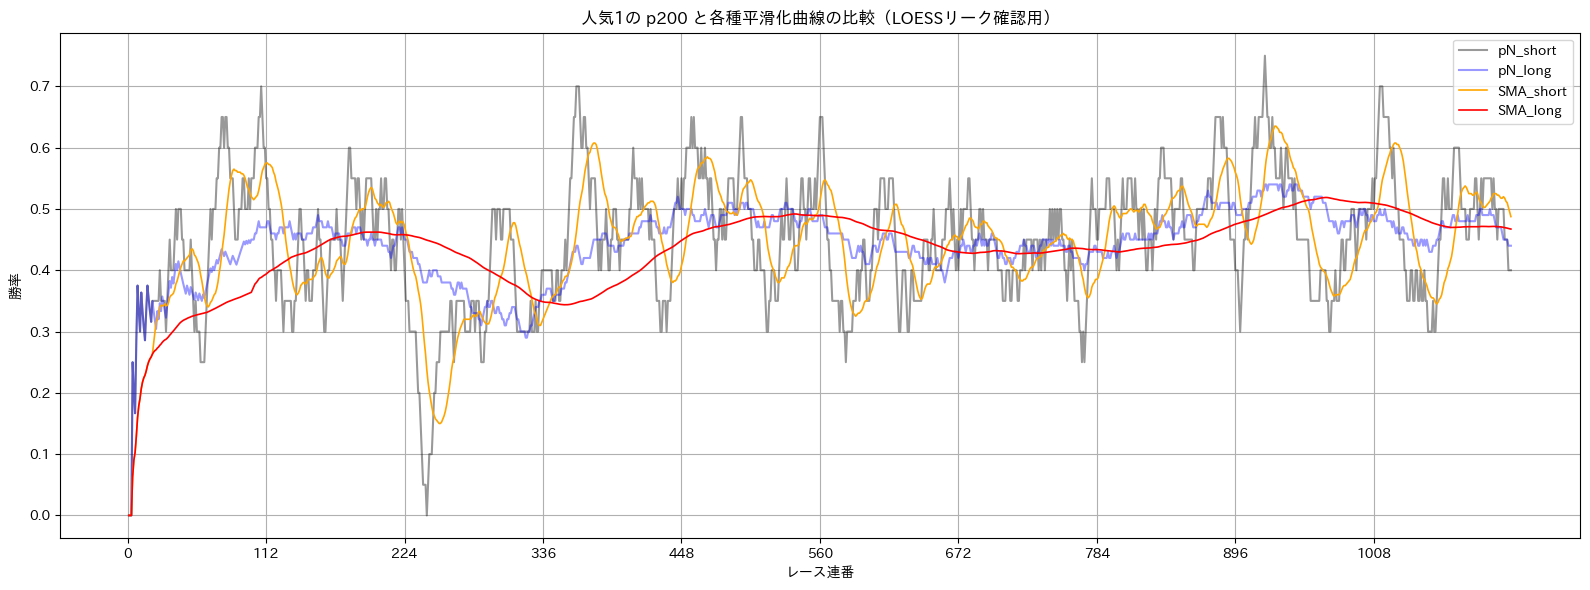

In [170]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess
from tqdm import tqdm

# --- 未来リークなしLOESS関数（逐次LOESS） ---
def rolling_loess(y, frac=0.1, window=200):
    """
    過去データのみを使った逐次LOESS（擬似LOESS）を計算する関数。
    """
    n = len(y)
    loess_seq = np.full(n, np.nan)
    for i in tqdm(range(n), desc="逐次LOESS計算中"):
        start = max(0, i - window)
        end = i + 1
        # i < windowのとき (start, end) = (0, i)
        # i >= windowのとき (start, end) = (i - window, i)
        y_sub = y[start:end]
        x_sub = np.arange(len(y_sub))
        if len(y_sub) < 5:
            loess_seq[i] = y_sub[i]
            continue
        # y_sub, x_subをプロットした際のなめらかな曲線を返す
        smoothed = lowess(y_sub, x_sub, frac=frac, return_sorted=False)
        loess_seq[i] = smoothed[-1]
    return loess_seq

# パラメータ
target_popularity =1
N_short = 20
N_long = 100
EMA_SPAN = 20
frac = 1.0
window = 200

# --- 対象人気を指定 ---
df_plot = full_pred_df[full_pred_df['popularity'] == target_popularity].copy()
df_plot['is_win'] = (df_plot['finish_rank'] == 1).astype(int)

# --- p100 / pN 計算 ---
df_plot['pN_short'] = df_plot['is_win'].rolling(N_short, min_periods=1).mean().shift(1)
df_plot['pN_long'] = df_plot['is_win'].rolling(N_long, min_periods=1).mean().shift(1)

# --- 移動平均 (SMA) ---
df_plot['SMA_short'] = df_plot['pN_short'].rolling(N_short, min_periods=1).mean()
df_plot['SMA_long'] = df_plot['pN_long'].rolling(N_long, min_periods=1).mean()

# --- 指数移動平均 (EMA) ---
# df_plot['pN_EMA'] = df_plot['pN'].ewm(span=EMA_SPAN, adjust=False).mean()

# --- 移動中央値 ---
# df_plot['pN_median'] = df_plot['pN'].rolling(N, min_periods=1).median()

# --- 通常LOESS（全データ使用・リークあり） ---
# df_plot['pN_LOESS_leaky'] = lowess(df_plot['pN'], np.arange(len(df_plot)), frac=frac, return_sorted=False)

# --- 未来リークなしLOESS（擬似LOESS） ---
# df_plot['pN_LOESS_no_leak'] = rolling_loess(df_plot['pN'].values, frac=frac, window=window)
# df_plot['pN_LOESS_no_leak_2'] = rolling_loess(df_plot['pN_LOESS_no_leak'].values, frac=frac, window=window)
# df_plot['pN_LOESS_no_leak_3'] = rolling_loess(df_plot['pN_SMA'].values, frac=frac, window=window)

# --- グラフ作成 ---
plt.figure(figsize=(16, 6))
x = np.arange(len(df_plot))

plt.plot(x, df_plot['pN_short'], label='pN_short', color='black', alpha=0.4)
plt.plot(x, df_plot['pN_long'], label='pN_long', color='blue', alpha=0.4)
plt.plot(x, df_plot['SMA_short'], label='SMA_short', color='orange', linewidth=1.2)
plt.plot(x, df_plot['SMA_long'], label='SMA_long', color='red', linewidth=1.2)
# plt.plot(x, df_plot['pN_EMA'], label='EMA', color='green', linewidth=1.2)
# plt.plot(x, df_plot['pN_median'], label='移動中央値', color='purple', linewidth=1.2)
# plt.plot(x, df_plot['pN_LOESS_leaky'], label='LOESS（全期間・未来リークあり）', color='red', linestyle='--')
# plt.plot(x, df_plot['pN_LOESS_no_leak'], label='逐次LOESS（未来リークなし）', color='black', linewidth=2)
# plt.plot(x, df_plot['pN_LOESS_no_leak_2'], label='逐次LOESS2（未来リークなし）', color='red', linewidth=2)
# plt.plot(x, df_plot['pN_LOESS_no_leak_3'], label='逐次LOESS3（未来リークなし）', color='purple', linewidth=2)

# 横軸の目盛りは一定間隔
step = max(1, len(x)//10)
plt.xticks(ticks=np.arange(0, len(x), step))

plt.xlabel('レース連番')
plt.ylabel('発生率')
plt.title(f'人気{target_popularity}の p{N} と各種平滑化曲線の比較（LOESSリーク確認用）')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


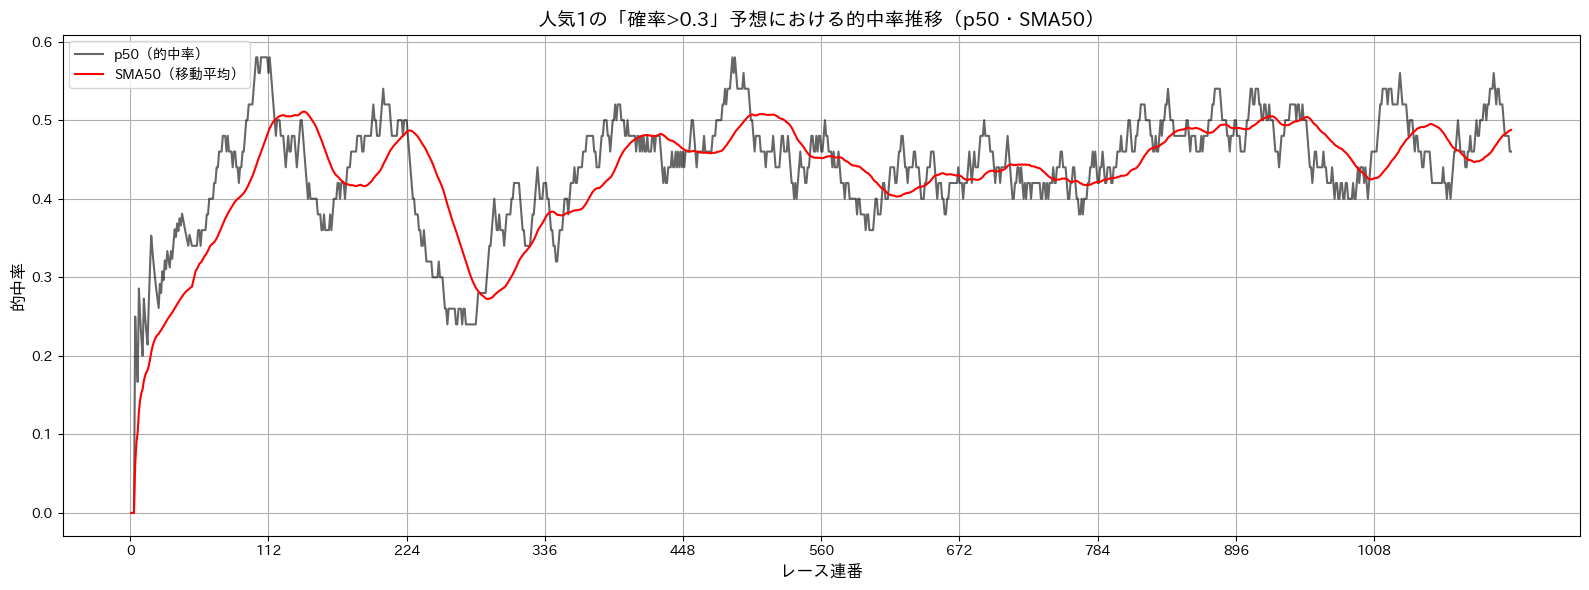

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess
from tqdm import tqdm

# --- パラメータ設定 ---
N = 50           # 直近過去Nレースで的中率を算出
SMA_N = 50       # 移動平均の期間
target_popularity = 1   # 対象人気
valid_year = 2024       # 検証対象年
threshold = 0.3         # 確率の閾値（この値以上なら1着予想とみなす）

# --- データ準備 ---
df_hit = full_pred_df.copy()

# 検証対象年でフィルタ
df_hit = df_hit[df_hit['race_date'].dt.year == valid_year].copy()

# --- 予測の判定 ---
# モデルの出力確率 pred_prob_m1 が threshold を超えたら「1着予想」とする
df_hit['predict_win'] = (df_hit['pred_prob_m1'] >= threshold).astype(int)

# 実際に1着になったか
df_hit['is_win'] = (df_hit['finish_rank'] == 1).astype(int)

# --- 的中判定 ---
# 「1着予想」かつ「実際に1着」なら的中
df_hit['is_hit'] = ((df_hit['predict_win'] == 1) & (df_hit['is_win'] == 1)).astype(int)

# --- 対象人気を指定 ---
df_plot = df_hit[df_hit['popularity'] == target_popularity].copy()
df_plot = df_plot.sort_values(by='race_date').reset_index(drop=True)

# --- pN（的中率）の計算 ---
df_plot['pN'] = df_plot['is_hit'].rolling(N, min_periods=1).mean().shift(1)

# --- 平滑化（移動平均: SMA） ---
df_plot['SMA'] = df_plot['pN'].rolling(SMA_N, min_periods=1).mean()

# --- グラフ作成 ---
plt.figure(figsize=(16, 6))
x = np.arange(len(df_plot))

plt.plot(x, df_plot['pN'], label=f'p{N}（的中率）', color='black', alpha=0.6)
plt.plot(x, df_plot['SMA'], label=f'SMA{SMA_N}（移動平均）', color='red', linewidth=1.5)

# 軸ラベル・タイトル設定
step = max(1, len(x)//10)
plt.xticks(ticks=np.arange(0, len(x), step))

plt.xlabel('レース連番', fontsize=12)
plt.ylabel('的中率', fontsize=12)
plt.title(f'人気{target_popularity}の「確率>{threshold}」予想における的中率推移（p{N}・SMA{SMA_N}）', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



🎯 人気1 のシミュレーション結果（mode=none）
的中率算出閾値(calc_threshold): 0.0
購入判定閾値(buy_threshold): 0.85
最初のN(50)件除外: True
----------------------------
購入数: 5
的中数: 3
的中率: 0.600（60.0%）
回収率: 0.840（84.0%）
ROI信頼区間(90%): [-73.500, 75.180]


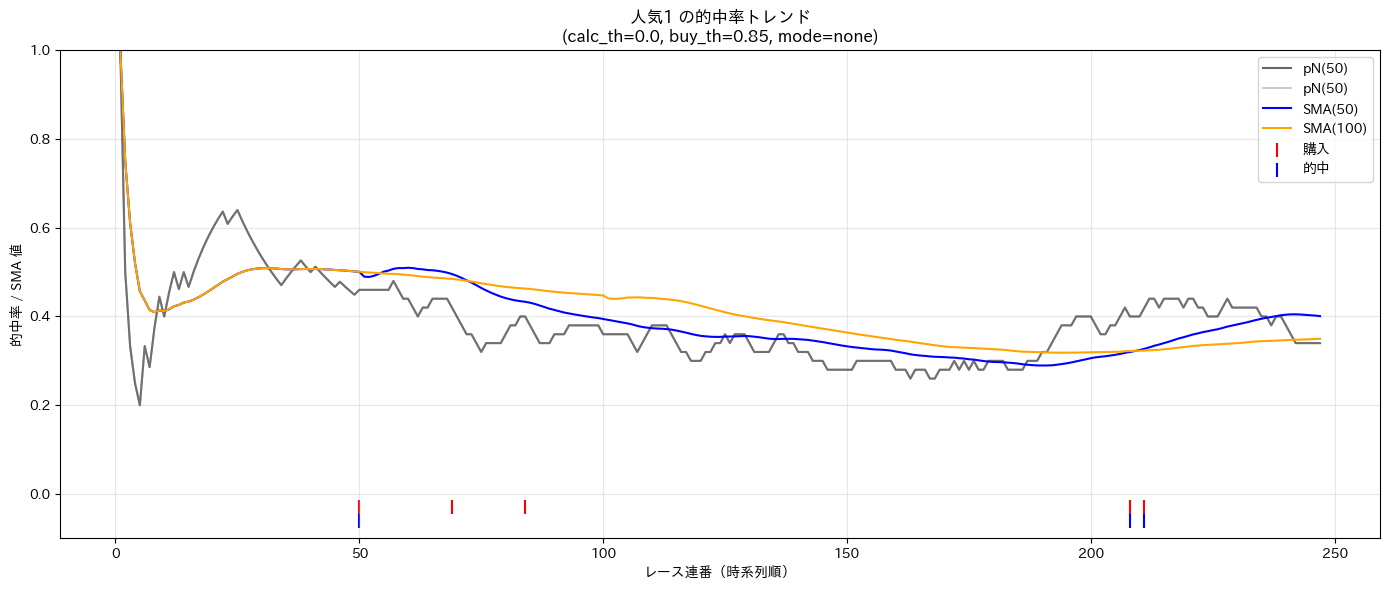

'\nresult, df_sim = simulate_single_popularity(\n    df=full_pred_df,\n    target_popularity=2,\n    calc_threshold=0.5,\n    buy_threshold=0.75,\n    N_short=100,\n    N_long=100,\n    N_SMA_short=10,\n    N_SMA_long=100,\n    pN_threshold=0.2,\n    buy_mode="pN_SMA_short_cross_th",\n    exclude_initial_N=True,\n)\n'

In [145]:
import matplotlib.pyplot as plt
from scipy import stats

# --- 信頼区間関数 ---
def confidence_interval(mean: float, std: float, n: int, confidence: float = 0.9):
    if n <= 1 or std == 0:
        return (mean, mean)
    t_value = stats.t.ppf((1 + confidence) / 2, df=n - 1)
    margin = t_value * std / np.sqrt(n)
    return (mean - margin, mean + margin)

# --- シミュレーション関数 ---
def simulate_single_popularity(
    df,
    target_popularity=1,
    calc_threshold=0.5,  # 的中率を計算するための閾値
    buy_threshold=0.8,   # 購入判断のための閾値
    N_short=100,
    N_long=100,
    N_SMA_short=100,
    N_SMA_long=100,
    pN_threshold=0.2,
    bet_amount=100,
    min_odds=1.1,
    max_odds=1000,
    buy_mode="slope",
    confidence=0.9,
    exclude_initial_N=True
):
    """
    指定人気の馬について、
    「的中率を算出するための閾値」と「購入の判断を行う閾値」を分離して
    シミュレーションを行う。

    exclude_initial_N=True の場合、
    最初の N_short レースは的中率が安定していないため購入対象外にする。
    """

    # --- 対象データ抽出 ---
    df_pop = df[df['popularity'] == target_popularity].copy()
    df_pop = df_pop.sort_values(by='race_date').reset_index(drop=True)
    df_pop['is_win'] = (df_pop['finish_rank'] == 1).astype(int)

    # --- 的中率算出用の的中定義 ---
    df_pop['predict_win_calc'] = (df_pop['pred_prob_m1'] >= calc_threshold).astype(int)
    df_pop['is_hit_calc'] = ((df_pop['predict_win_calc'] == 1) & (df_pop['is_win'] == 1)).astype(int)

    # --- pN, SMA 計算 ---
    df_pop['pN_short'] = df_pop['is_hit_calc'].rolling(N_short, min_periods=1).mean().shift(1)
    df_pop['pN_long']  = df_pop['is_hit_calc'].rolling(N_long,  min_periods=1).mean().shift(1)
    df_pop['SMA_short'] = df_pop['pN_short'].rolling(N_SMA_short, min_periods=1).mean()
    df_pop['SMA_long']  = df_pop['pN_long'].rolling(N_SMA_long,  min_periods=1).mean()
    df_pop['SMA_short_slope'] = df_pop['SMA_short'].diff()
    df_pop['SMA_long_slope']  = df_pop['SMA_long'].diff()

    # --- 購入条件定義 ---
    if buy_mode == "none":
        df_pop['cond'] = (df_pop['pred_prob_m1'] >= buy_threshold)
    elif buy_mode == "slope":
        df_pop['cond'] = (
            (df_pop['SMA_short_slope'] > 0) &
            (df_pop['pred_prob_m1'] >= buy_threshold)
        )
    elif buy_mode == "SMA_SMA_cross":
        df_pop['cond'] = (
            (df_pop['SMA_short'] > df_pop['SMA_long']) &
            (df_pop['pred_prob_m1'] >= buy_threshold)
        )
    elif buy_mode == "pN_SMA_short_cross":
        df_pop['cond'] = (
            (df_pop['pN_short'] > df_pop['SMA_short']) &
            (df_pop['pred_prob_m1'] >= buy_threshold)
        )
    elif buy_mode == "pN_SMA_short_cross_th":
        df_pop['cond'] = (
            (df_pop['pN_short'] > df_pop['SMA_short']) &
            (df_pop['pN_short'] > pN_threshold) &
            (df_pop['pred_prob_m1'] >= buy_threshold)
        )
    elif buy_mode == "pN_SMA_short_cross_slope_th":
        df_pop['cond'] = (
            (df_pop['pN_short'] > df_pop['SMA_short']) &
            (df_pop['pN_short'] > pN_threshold) &
            (df_pop['SMA_short_slope'] > 0) &
            (df_pop['pred_prob_m1'] >= buy_threshold)
        )
    elif buy_mode == "slope_cross":
        df_pop['cond'] = (
            (df_pop['SMA_long_slope'] > 0) &
            (df_pop['SMA_short'] > df_pop['SMA_long']) &
            (df_pop['pred_prob_m1'] >= buy_threshold)
        )
    else:
        raise ValueError("存在しない cond が指定されました。")

    # --- ★最初のNレースを除外 ---
    if exclude_initial_N:
        df_pop.loc[:N_short-1, 'cond'] = False

    # --- 購入データ抽出 ---
    bets = df_pop[df_pop['cond']].copy()
    bets = bets[(bets['odds'] >= min_odds) & (bets['odds'] <= max_odds)]

    df_pop.to_csv('C:\\Users\\ryo\\Downloads\\df_pop.csv', index=False, encoding='cp932')
    
    total_bets = len(bets)
    total_spent = total_bets * bet_amount
    wins = bets['is_win'].sum()

    # --- 結果計算 ---
    if total_bets == 0:
        print("⚠ 該当する購入データがありません。")
        return None, df_pop

    accuracy = wins / total_bets
    bets['payout_each'] = bets['is_win'] * bets['odds'] * bet_amount
    total_payout = bets['payout_each'].sum()
    roi = total_payout / total_spent if total_spent > 0 else 0

    std = bets['payout_each'].std(ddof=1) if total_bets > 1 else 0
    ci_lower, ci_upper = confidence_interval(roi, std, total_bets, confidence)

    result = {
        'popularity': target_popularity,
        'bets': total_bets,
        'wins': wins,
        'accuracy': accuracy,
        'roi': roi,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'spent': total_spent,
        'payout': total_payout
    }

    # --- 結果表示 ---
    print("\n============================")
    print(f"🎯 人気{target_popularity} のシミュレーション結果（mode={buy_mode}）")
    print("============================")
    print(f"的中率算出閾値(calc_threshold): {calc_threshold}")
    print(f"購入判定閾値(buy_threshold): {buy_threshold}")
    print(f"最初のN({N_short})件除外: {exclude_initial_N}")
    print("----------------------------")
    print(f"購入数: {total_bets}")
    print(f"的中数: {wins}")
    print(f"的中率: {accuracy:.3f}（{accuracy:.1%}）")
    print(f"回収率: {roi:.3f}（{roi:.1%}）")
    print(f"ROI信頼区間({confidence*100:.0f}%): [{ci_lower:.3f}, {ci_upper:.3f}]")

    # --- グラフ出力 ---
    fig, ax1 = plt.subplots(figsize=(14, 6))
    ax1.plot(df_pop.index, df_pop['pN_short'], color='black', alpha=0.6, label=f'pN({N_short})')
    ax1.plot(df_pop.index, df_pop['pN_long'], color='gray', alpha=0.4, label=f'pN({N_long})')
    ax1.plot(df_pop.index, df_pop['SMA_short'], color='blue', label=f'SMA({N_SMA_short})')
    ax1.plot(df_pop.index, df_pop['SMA_long'], color='orange', label=f'SMA({N_SMA_long})')
    ax1.set_title(
        f"人気{target_popularity} の的中率トレンド\n"
        f"(calc_th={calc_threshold}, buy_th={buy_threshold}, mode={buy_mode})"
    )
    ax1.set_xlabel("レース連番（時系列順）")
    ax1.set_ylabel("的中率 / SMA 値")
    ax1.grid(alpha=0.3)

    # --- 購入点と的中点をマーカーで可視化 ---
    y_buy = -0.03
    y_hit = -0.06
    buy_points = df_pop[df_pop['cond']]
    hit_points = buy_points[buy_points['is_win'] == 1]
    ax1.scatter(buy_points.index, [y_buy]*len(buy_points),
                color='red', marker='|', s=100, label='購入')
    ax1.scatter(hit_points.index, [y_hit]*len(hit_points),
                color='blue', marker='|', s=100, label='的中')

    ax1.legend(loc='upper right')
    ax1.set_ylim(-0.1, 1.0)
    plt.tight_layout()
    plt.show()

    return result, df_pop

result, df_sim = simulate_single_popularity(
    df=full_pred_df,
    target_popularity=1,
    calc_threshold=0.0,
    buy_threshold=0.85,
    N_short=50,
    N_long=50,
    N_SMA_short=50,
    N_SMA_long=100,
    min_odds=1.1,
    max_odds=10000,
    pN_threshold=0.0,
    buy_mode="none",
    exclude_initial_N=True,
)
'''
result, df_sim = simulate_single_popularity(
    df=full_pred_df,
    target_popularity=2,
    calc_threshold=0.5,
    buy_threshold=0.75,
    N_short=100,
    N_long=100,
    N_SMA_short=10,
    N_SMA_long=100,
    pN_threshold=0.2,
    buy_mode="pN_SMA_short_cross_th",
    exclude_initial_N=True,
)
'''


🎯 条件 13 人気ごとシミュレーション
人気：1.0を処理中
人気：2.0を処理中
人気：3.0を処理中
人気：4.0を処理中
人気：5.0を処理中
人気：6.0を処理中
人気：7.0を処理中
人気：8.0を処理中
人気：9.0を処理中

--- パラメータ設定 ---
N=20, bet_amount=100, EMA_SPAN=10, prob_threshold=0.5
loess_frac=1.0, min_odds=1.1, max_odds=10000
fillna_option=None, skip_initial=20

popularity  bets  wins   spent  payout accuracy_pct roi_pct
       1.0   529   243  52,900  42,790        45.94   80.89
       2.0   396    86  39,600  28,460        21.72   71.87
       3.0   322    49  32,200  27,260        15.22   84.66
       4.0   272    28  27,200  24,470        10.29   89.96
       5.0   162     6  16,200   9,070         3.70   55.99
       6.0   104     8  10,400  12,720         7.69  122.31
       7.0    39     0   3,900       0         0.00    0.00
       8.0    24     2   2,400   4,680         8.33  195.00
       9.0     0     0       0       0         0.00    0.00
        合計  1848   422 184,800 149,450        22.84   80.87

🎯 閾値スキャン開始


人気別処理:  11%|████████                                                                | 1/9 [00:57<07:42, 57.81s/it]

pop=1.0, thr=0.00000, bets= 529, acc=0.459, ROI=0.809
pop=1.0, thr=0.00025, bets= 436, acc=0.466, ROI=0.822
pop=1.0, thr=0.00050, bets= 366, acc=0.462, ROI=0.828
pop=1.0, thr=0.00075, bets= 319, acc=0.461, ROI=0.830
pop=1.0, thr=0.00100, bets= 282, acc=0.457, ROI=0.821
pop=1.0, thr=0.00125, bets= 219, acc=0.452, ROI=0.800
pop=1.0, thr=0.00150, bets= 164, acc=0.476, ROI=0.824
pop=1.0, thr=0.00175, bets= 119, acc=0.462, ROI=0.777
pop=1.0, thr=0.00200, bets= 104, acc=0.462, ROI=0.777
pop=1.0, thr=0.00225, bets=  89, acc=0.449, ROI=0.756
pop=1.0, thr=0.00250, bets=  85, acc=0.459, ROI=0.761
pop=1.0, thr=0.00275, bets=  76, acc=0.461, ROI=0.758
pop=1.0, thr=0.00300, bets=  66, acc=0.455, ROI=0.748
pop=1.0, thr=0.00325, bets=  64, acc=0.469, ROI=0.772
pop=1.0, thr=0.00350, bets=  60, acc=0.450, ROI=0.698
pop=1.0, thr=0.00375, bets=  55, acc=0.455, ROI=0.702
pop=1.0, thr=0.00400, bets=  52, acc=0.462, ROI=0.719
pop=1.0, thr=0.00425, bets=  45, acc=0.444, ROI=0.687
pop=1.0, thr=0.00450, bets= 

人気別処理:  22%|████████████████                                                        | 2/9 [02:07<07:34, 64.95s/it]

pop=2.0, thr=0.00000, bets= 396, acc=0.217, ROI=0.719
pop=2.0, thr=0.00025, bets= 356, acc=0.222, ROI=0.735
pop=2.0, thr=0.00050, bets= 318, acc=0.230, ROI=0.758
pop=2.0, thr=0.00075, bets= 282, acc=0.220, ROI=0.720
pop=2.0, thr=0.00100, bets= 252, acc=0.210, ROI=0.689
pop=2.0, thr=0.00125, bets= 219, acc=0.219, ROI=0.720
pop=2.0, thr=0.00150, bets= 170, acc=0.241, ROI=0.768
pop=2.0, thr=0.00175, bets= 142, acc=0.254, ROI=0.814
pop=2.0, thr=0.00200, bets= 127, acc=0.236, ROI=0.765
pop=2.0, thr=0.00225, bets= 108, acc=0.194, ROI=0.641
pop=2.0, thr=0.00250, bets=  92, acc=0.207, ROI=0.675
pop=2.0, thr=0.00275, bets=  82, acc=0.220, ROI=0.720
pop=2.0, thr=0.00300, bets=  70, acc=0.229, ROI=0.736
pop=2.0, thr=0.00325, bets=  50, acc=0.200, ROI=0.646
pop=2.0, thr=0.00350, bets=  34, acc=0.147, ROI=0.429
pop=2.0, thr=0.00375, bets=  20, acc=0.150, ROI=0.460
pop=2.0, thr=0.00400, bets=  19, acc=0.158, ROI=0.484
pop=2.0, thr=0.00425, bets=  17, acc=0.176, ROI=0.541
pop=2.0, thr=0.00450, bets= 

人気別処理:  33%|████████████████████████                                                | 3/9 [03:06<06:11, 61.91s/it]

pop=3.0, thr=0.00000, bets= 322, acc=0.152, ROI=0.847
pop=3.0, thr=0.00025, bets= 290, acc=0.155, ROI=0.874
pop=3.0, thr=0.00050, bets= 243, acc=0.156, ROI=0.902
pop=3.0, thr=0.00075, bets= 202, acc=0.158, ROI=0.889
pop=3.0, thr=0.00100, bets= 178, acc=0.163, ROI=0.926
pop=3.0, thr=0.00125, bets= 143, acc=0.140, ROI=0.829
pop=3.0, thr=0.00150, bets= 112, acc=0.134, ROI=0.809
pop=3.0, thr=0.00175, bets=  91, acc=0.099, ROI=0.652
pop=3.0, thr=0.00200, bets=  71, acc=0.099, ROI=0.697
pop=3.0, thr=0.00225, bets=  57, acc=0.088, ROI=0.651
pop=3.0, thr=0.00250, bets=  49, acc=0.082, ROI=0.647
pop=3.0, thr=0.00275, bets=  42, acc=0.071, ROI=0.586
pop=3.0, thr=0.00300, bets=  39, acc=0.077, ROI=0.631
pop=3.0, thr=0.00325, bets=  33, acc=0.091, ROI=0.745
pop=3.0, thr=0.00350, bets=  30, acc=0.100, ROI=0.820
pop=3.0, thr=0.00375, bets=  25, acc=0.120, ROI=0.984
pop=3.0, thr=0.00400, bets=  23, acc=0.130, ROI=1.070
pop=3.0, thr=0.00425, bets=  19, acc=0.158, ROI=1.295
pop=3.0, thr=0.00450, bets= 

人気別処理:  44%|████████████████████████████████                                        | 4/9 [04:02<04:58, 59.70s/it]

pop=4.0, thr=0.00000, bets= 272, acc=0.103, ROI=0.900
pop=4.0, thr=0.00025, bets= 212, acc=0.104, ROI=0.906
pop=4.0, thr=0.00050, bets= 154, acc=0.078, ROI=0.699
pop=4.0, thr=0.00075, bets= 124, acc=0.065, ROI=0.628
pop=4.0, thr=0.00100, bets= 102, acc=0.078, ROI=0.764
pop=4.0, thr=0.00125, bets=  77, acc=0.065, ROI=0.558
pop=4.0, thr=0.00150, bets=  65, acc=0.046, ROI=0.437
pop=4.0, thr=0.00175, bets=  42, acc=0.048, ROI=0.412
pop=4.0, thr=0.00200, bets=  32, acc=0.062, ROI=0.541
pop=4.0, thr=0.00225, bets=  17, acc=0.059, ROI=0.635
pop=4.0, thr=0.00250, bets=  13, acc=0.077, ROI=0.831
pop=4.0, thr=0.00275, bets=  10, acc=0.000, ROI=0.000
pop=4.0, thr=0.00300, bets=   8, acc=0.000, ROI=0.000
pop=4.0, thr=0.00325, bets=   7, acc=0.000, ROI=0.000
pop=4.0, thr=0.00350, bets=   7, acc=0.000, ROI=0.000
pop=4.0, thr=0.00375, bets=   7, acc=0.000, ROI=0.000
pop=4.0, thr=0.00400, bets=   7, acc=0.000, ROI=0.000
pop=4.0, thr=0.00425, bets=   7, acc=0.000, ROI=0.000
pop=4.0, thr=0.00450, bets= 

人気別処理:  56%|████████████████████████████████████████                                | 5/9 [05:00<03:56, 59.17s/it]

pop=5.0, thr=0.00000, bets= 162, acc=0.037, ROI=0.560
pop=5.0, thr=0.00025, bets= 101, acc=0.040, ROI=0.687
pop=5.0, thr=0.00050, bets=  61, acc=0.049, ROI=0.905
pop=5.0, thr=0.00075, bets=  38, acc=0.026, ROI=0.682
pop=5.0, thr=0.00100, bets=  23, acc=0.000, ROI=0.000
pop=5.0, thr=0.00125, bets=   9, acc=0.000, ROI=0.000
pop=5.0, thr=0.00150, bets=   6, acc=0.000, ROI=0.000
pop=5.0, thr=0.00175, bets=   4, acc=0.000, ROI=0.000
pop=5.0, thr=0.00200, bets=   4, acc=0.000, ROI=0.000
pop=5.0, thr=0.00225, bets=   2, acc=0.000, ROI=0.000
pop=5.0, thr=0.00250, bets=   2, acc=0.000, ROI=0.000
pop=5.0, thr=0.00275, bets=   1, acc=0.000, ROI=0.000
pop=5.0, thr=0.00300, bets=   1, acc=0.000, ROI=0.000
pop=5.0, thr=0.00325, bets=   1, acc=0.000, ROI=0.000
pop=5.0, thr=0.00350, bets=   1, acc=0.000, ROI=0.000
pop=5.0, thr=0.00375, bets=   1, acc=0.000, ROI=0.000
pop=5.0, thr=0.00400, bets=   1, acc=0.000, ROI=0.000
pop=5.0, thr=0.00425, bets=   1, acc=0.000, ROI=0.000
pop=5.0, thr=0.00450, bets= 

人気別処理:  67%|████████████████████████████████████████████████                        | 6/9 [05:58<02:56, 58.89s/it]

pop=6.0, thr=0.00000, bets= 104, acc=0.077, ROI=1.223
pop=6.0, thr=0.00025, bets=  61, acc=0.049, ROI=1.057
pop=6.0, thr=0.00050, bets=  35, acc=0.057, ROI=0.909
pop=6.0, thr=0.00075, bets=  22, acc=0.091, ROI=1.445
pop=6.0, thr=0.00100, bets=  13, acc=0.154, ROI=2.446
pop=6.0, thr=0.00125, bets=   8, acc=0.000, ROI=0.000
pop=6.0, thr=0.00150, bets=   7, acc=0.000, ROI=0.000
pop=6.0, thr=0.00175, bets=   4, acc=0.000, ROI=0.000
pop=6.0, thr=0.00200, bets=   2, acc=0.000, ROI=0.000
pop=6.0, thr=0.00225, bets=   2, acc=0.000, ROI=0.000
pop=6.0, thr=0.00250, bets=   2, acc=0.000, ROI=0.000
pop=6.0, thr=0.00275, bets=   2, acc=0.000, ROI=0.000
pop=6.0, thr=0.00300, bets=   2, acc=0.000, ROI=0.000
pop=6.0, thr=0.00325, bets=   2, acc=0.000, ROI=0.000
pop=6.0, thr=0.00350, bets=   2, acc=0.000, ROI=0.000
pop=6.0, thr=0.00375, bets=   2, acc=0.000, ROI=0.000
pop=6.0, thr=0.00400, bets=   2, acc=0.000, ROI=0.000
pop=6.0, thr=0.00425, bets=   2, acc=0.000, ROI=0.000
pop=6.0, thr=0.00450, bets= 

人気別処理:  78%|████████████████████████████████████████████████████████                | 7/9 [06:56<01:57, 58.52s/it]

pop=7.0, thr=0.00000, bets=  39, acc=0.000, ROI=0.000
pop=7.0, thr=0.00025, bets=  13, acc=0.000, ROI=0.000
pop=7.0, thr=0.00050, bets=  11, acc=0.000, ROI=0.000
pop=7.0, thr=0.00075, bets=   8, acc=0.000, ROI=0.000
pop=7.0, thr=0.00100, bets=   7, acc=0.000, ROI=0.000
pop=7.0, thr=0.00125, bets=   3, acc=0.000, ROI=0.000
pop=7.0, thr=0.00150, bets=   1, acc=0.000, ROI=0.000
pop=7.0, thr=0.00175, bets=   1, acc=0.000, ROI=0.000
pop=7.0, thr=0.00200, bets=   1, acc=0.000, ROI=0.000
pop=7.0, thr=0.00225, bets=   0, acc=0.000, ROI=0.000
pop=7.0, thr=0.00250, bets=   0, acc=0.000, ROI=0.000
pop=7.0, thr=0.00275, bets=   0, acc=0.000, ROI=0.000
pop=7.0, thr=0.00300, bets=   0, acc=0.000, ROI=0.000
pop=7.0, thr=0.00325, bets=   0, acc=0.000, ROI=0.000
pop=7.0, thr=0.00350, bets=   0, acc=0.000, ROI=0.000
pop=7.0, thr=0.00375, bets=   0, acc=0.000, ROI=0.000
pop=7.0, thr=0.00400, bets=   0, acc=0.000, ROI=0.000
pop=7.0, thr=0.00425, bets=   0, acc=0.000, ROI=0.000
pop=7.0, thr=0.00450, bets= 

人気別処理:  89%|████████████████████████████████████████████████████████████████        | 8/9 [07:51<00:57, 57.35s/it]

pop=8.0, thr=0.00000, bets=  24, acc=0.083, ROI=1.950
pop=8.0, thr=0.00025, bets=  10, acc=0.100, ROI=1.650
pop=8.0, thr=0.00050, bets=   7, acc=0.143, ROI=2.357
pop=8.0, thr=0.00075, bets=   4, acc=0.250, ROI=4.125
pop=8.0, thr=0.00100, bets=   4, acc=0.250, ROI=4.125
pop=8.0, thr=0.00125, bets=   1, acc=0.000, ROI=0.000
pop=8.0, thr=0.00150, bets=   1, acc=0.000, ROI=0.000
pop=8.0, thr=0.00175, bets=   1, acc=0.000, ROI=0.000
pop=8.0, thr=0.00200, bets=   1, acc=0.000, ROI=0.000
pop=8.0, thr=0.00225, bets=   1, acc=0.000, ROI=0.000
pop=8.0, thr=0.00250, bets=   1, acc=0.000, ROI=0.000
pop=8.0, thr=0.00275, bets=   1, acc=0.000, ROI=0.000
pop=8.0, thr=0.00300, bets=   1, acc=0.000, ROI=0.000
pop=8.0, thr=0.00325, bets=   1, acc=0.000, ROI=0.000
pop=8.0, thr=0.00350, bets=   1, acc=0.000, ROI=0.000
pop=8.0, thr=0.00375, bets=   1, acc=0.000, ROI=0.000
pop=8.0, thr=0.00400, bets=   1, acc=0.000, ROI=0.000
pop=8.0, thr=0.00425, bets=   0, acc=0.000, ROI=0.000
pop=8.0, thr=0.00450, bets= 

人気別処理: 100%|████████████████████████████████████████████████████████████████████████| 9/9 [08:48<00:00, 58.75s/it]

pop=9.0, thr=0.00000, bets=   0, acc=0.000, ROI=0.000
pop=9.0, thr=0.00025, bets=   0, acc=0.000, ROI=0.000
pop=9.0, thr=0.00050, bets=   0, acc=0.000, ROI=0.000
pop=9.0, thr=0.00075, bets=   0, acc=0.000, ROI=0.000
pop=9.0, thr=0.00100, bets=   0, acc=0.000, ROI=0.000
pop=9.0, thr=0.00125, bets=   0, acc=0.000, ROI=0.000
pop=9.0, thr=0.00150, bets=   0, acc=0.000, ROI=0.000
pop=9.0, thr=0.00175, bets=   0, acc=0.000, ROI=0.000
pop=9.0, thr=0.00200, bets=   0, acc=0.000, ROI=0.000
pop=9.0, thr=0.00225, bets=   0, acc=0.000, ROI=0.000
pop=9.0, thr=0.00250, bets=   0, acc=0.000, ROI=0.000
pop=9.0, thr=0.00275, bets=   0, acc=0.000, ROI=0.000
pop=9.0, thr=0.00300, bets=   0, acc=0.000, ROI=0.000
pop=9.0, thr=0.00325, bets=   0, acc=0.000, ROI=0.000
pop=9.0, thr=0.00350, bets=   0, acc=0.000, ROI=0.000
pop=9.0, thr=0.00375, bets=   0, acc=0.000, ROI=0.000
pop=9.0, thr=0.00400, bets=   0, acc=0.000, ROI=0.000
pop=9.0, thr=0.00425, bets=   0, acc=0.000, ROI=0.000
pop=9.0, thr=0.00450, bets= 


C:\Users\ryo\AppData\Local\Temp\ipykernel_5744\3335822611.py:338: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\ryo\AppData\Local\Temp\ipykernel_5744\3335822611.py:338: UserWarning: Glyph 20013 (\N{CJK UNIFIED IDEOGRAPH-4E2D}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\ryo\AppData\Local\Temp\ipykernel_5744\3335822611.py:338: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\ryo\AppData\Local\Temp\ipykernel_5744\3335822611.py:338: UserWarning: Glyph 38334 (\N{CJK UNIFIED IDEOGRAPH-95BE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\ryo\AppData\Local\Temp\ipykernel_5744\3335822611.py:338: UserWarning: Glyph 20516 (\N{CJK UNIFIED IDEOGRAPH-5024}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\ryo\AppData\Local\Temp\ipykernel_5744\3335822611.py:338: UserWarning: Glyph 21029 (\N{CJK UNIFIED IDEOGRAPH-5225}) missing fr

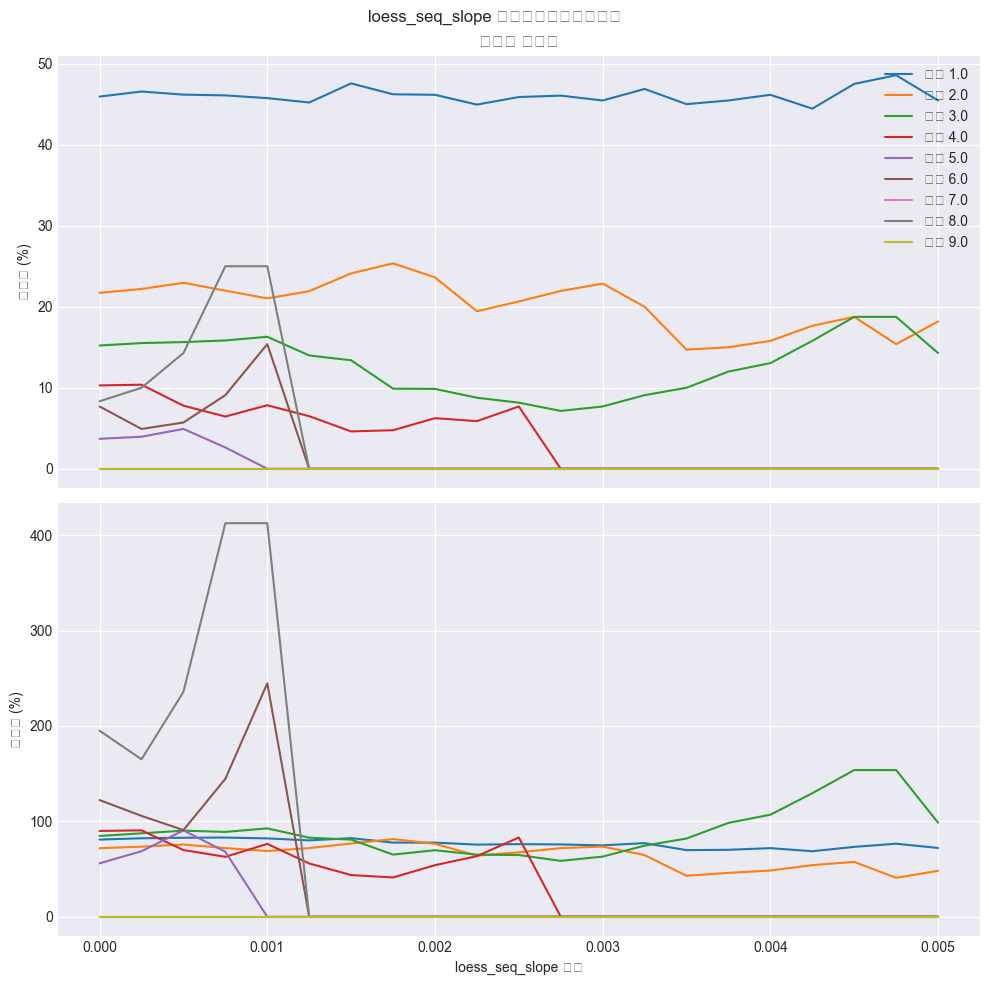


✅ 閾値スキャン完了！結果をCSVに保存しました。


In [7]:
from scipy import stats
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.interpolate import interp1d

# --- 信頼区間関数 ---
def confidence_interval(mean: float, std: float, n: int, confidence: float = 0.9):
    if n <= 1 or std == 0:
        return (mean, mean)
    t_value = stats.t.ppf((1 + confidence) / 2, df=n - 1)
    margin = t_value * std / np.sqrt(n)
    return (mean - margin, mean + margin)

# --- パラメータ ---
N = 20
bet_amount = 100
EMA_SPAN = 10
prob_threshold = 0.5
frac = 1.0
window = 200
min_odds = 1.1
max_odds = 10000
interp_factor = 10

# --- シミュレーション関数 ---
def simulate_hits(df, cond_col=None, min_odds=None, max_odds=None):
    if cond_col is not None:
        if isinstance(cond_col, str):
            bets = df[df[cond_col]].copy()
        else:
            # cond_colがSeriesならそのまま使う
            bets = df[cond_col].copy()
    else:
        bets = df.copy()
    
    if min_odds is not None:
        bets = bets[bets['odds'] >= min_odds]
    if max_odds is not None:
        bets = bets[bets['odds'] <= max_odds]

    total_bets = len(bets)
    total_spent = total_bets * bet_amount

    if total_bets == 0:
        return {
            'bets': 0, 'wins': 0, 'accuracy': 0,
            'roi': 0, 'payout': 0, 'spent': 0,
            'ci': (np.nan, np.nan)
        }

    wins = bets['is_win'].sum()
    accuracy = wins / total_bets
    bets['payout_each'] = bets['is_win'] * bets['odds'] * bet_amount
    payout = bets['payout_each'].sum()
    roi = payout / total_spent if total_spent > 0 else 0
    std = bets['payout_each'].std(ddof=1) if total_bets > 1 else 0
    lower, upper = confidence_interval(roi, std, total_bets)

    return {
        'bets': total_bets,
        'wins': wins,
        'accuracy': accuracy,
        'roi': roi,
        'payout': payout,
        'spent': total_spent,
        'ci': (lower, upper)
    }

# --- 逐次LOESS計算（fillnaオプション & skip_initialオプション付き） ---
def compute_sequential_loess(df, points_name, frac, window, fillna_option=None, skip_initial=0):
    
    # fillnaオプション処理
    if fillna_option is not None:
        df[points_name] = df[points_name].fillna(fillna_option)
    
    loess_seq = []
    for i in range(len(df)):
        if i < skip_initial:
            loess_seq.append(np.nan)
            continue

        start_idx = max(skip_initial, i - window)
        end_idx = i + 1
        if end_idx - start_idx < 2:
            loess_seq.append(df[points_name].iloc[i])
            continue
        smoothed = lowess(df[points_name].iloc[start_idx:end_idx], 
                          np.arange(end_idx - start_idx), frac=frac, return_sorted=False)
        loess_seq.append(smoothed[-1])
        
    df['loess_seq'] = loess_seq
    df['loess_seq_slope'] = np.diff(df['loess_seq'], prepend=np.nan)
    df['loess_seq_slope2'] = np.diff(df['loess_seq_slope'], prepend=np.nan)
    # df['loess_seq_slope'] = np.gradient(df['loess_seq'], edge_order=2)
    # df['loess_seq_slope2'] = np.gradient(df['loess_seq_slope'], edge_order=2)
    
    return df

def compute_sequential_loess_smooth(df, N=100, frac=0.1, window=200, interp_factor=5, skip_initial=0, fillna_option=None):
    df = df.copy()
    df['pN'] = df['is_win'].rolling(N, min_periods=1).mean().shift(1)
    
    if fillna_option is not None:
        df['pN'] = df['pN'].fillna(fillna_option)
    
    loess_seq = []
    loess_slope = []
    loess_slope2 = []

    for i in range(len(df)):
        if i < skip_initial:
            loess_seq.append(np.nan)
            loess_slope.append(np.nan)
            loess_slope2.append(np.nan)
            continue

        start_idx = max(skip_initial, i - window)
        end_idx = i + 1
        if end_idx - start_idx < 2:
            loess_seq.append(df['pN'].iloc[i])
            loess_slope.append(np.nan)
            loess_slope2.append(np.nan)
            continue

        x = np.arange(end_idx - start_idx)
        y = df['pN'].iloc[start_idx:end_idx].values

        # NaN除去
        mask = ~np.isnan(y)
        x = x[mask]
        y = y[mask]
        if len(x) < 2:
            loess_seq.append(np.nan)
            loess_slope.append(np.nan)
            loess_slope2.append(np.nan)
            continue

        smoothed = lowess(y, x, frac=frac, return_sorted=False)

        # 補間方法を切り替え
        kind = 'cubic' if len(x) >= 4 else 'linear'
        interp_x = np.linspace(x.min(), x.max(), len(x) * interp_factor)
        f_interp = interp1d(x, smoothed, kind=kind, fill_value='extrapolate')
        dense_y = f_interp(interp_x)

        dx = interp_x[1] - interp_x[0]
        slope = np.gradient(dense_y, dx)
        slope2 = np.gradient(slope, dx)

        loess_seq.append(dense_y[-1])
        loess_slope.append(slope[-1])
        loess_slope2.append(slope2[-1])

    df['loess_seq'] = loess_seq
    df['loess_seq_slope'] = loess_slope
    df['loess_seq_slope2'] = loess_slope2

    return df

# --- 条件定義 ---
conditions = {
    '09': lambda df: df['loess_seq_slope'] > 0,
    '10': lambda df: (df['loess_seq_slope'] > 0) & (df['pN'] < df['loess_seq']),
    '11': lambda df: (df['loess_seq_slope'].shift(2) > 0) & (df['loess_seq_slope2'].shift(2) > 0),
    '12': lambda df: (df['loess_seq_slope'].shift(1) > 0) & (df['loess_seq_slope2'].shift(2) > 0),   
    '13': lambda df: df['loess_seq_slope'] > 0,
    '14': lambda df: df['loess_seq_slope2'] > 0,
    '15': lambda df: (df['pN'] > df['loess_seq']) & (df['loess_seq_slope'] > 0),
    '16': lambda df: (df['pN'] > df['loess_seq']),
    '17': lambda df: (df['loess_seq_slope'] > 0) & (df['loess_seq_slope2'] > 0),
    '18': lambda df: (df['loess_seq_slope'] > 0) & (df['loess_seq_slope2'] < 0)
}

# --- ここでどれを計算するか指定 ---
target_cond = '13' # conditionsで定義されているどれか
fillna_option = None  # None または 0 など
skip_initial = N    # 最初の N 行を無視（0またはNにする）

print("\n" + "="*30)
print(f"🎯 条件 {target_cond} 人気ごとシミュレーション")
print("="*30)

results_all = []
all_bets_df = []

for pop in sorted(full_pred_df['popularity'].unique()):

    print(f'人気：{pop}を処理中')
    
    df_pop = full_pred_df[full_pred_df['popularity'] == pop].copy()
    df_pop['is_win'] = (df_pop['finish_rank'] == 1).astype(int)

    # --- 1回目の逐次LOESS ---
    df_pop['pN'] = df_pop['is_win'].rolling(N, min_periods=1).mean().shift(1)
    df_pop = compute_sequential_loess(df_pop, 'pN', frac, window, fillna_option, skip_initial)

    # --- 2回目の逐次LOESS（loess_seqをもとに再平滑化）---
    # 1回目で得られた loess_seq を "is_win" の代わりに使って2段階目を実施
    df_pop_for_second = df_pop.copy()
    df_pop = compute_sequential_loess(df_pop_for_second, 'loess_seq', frac, window, fillna_option, skip_initial)

    # （必要なら loess_seq_2 など別名で保持したい場合）
    # df_pop['loess_seq_2'] = df_pop['loess_seq']
    # df_pop.drop(columns=['loess_seq_slope', 'loess_seq_slope2'], inplace=True)
    # df_pop.rename(columns={'loess_seq': 'loess_seq_2',
    #                        'loess_seq_slope': 'loess_seq_slope_2',
    #                        'loess_seq_slope2': 'loess_seq_slope2_2'}, inplace=True)

    # --- 条件判定 ---
    
    df_pop['cond'] = conditions[target_cond](df_pop) & (df_pop['pred_prob_m1'] >= prob_threshold)

    # --- シミュレーション ---
    res = simulate_hits(df_pop, 'cond', min_odds, max_odds)

    results_all.append({
        'popularity': pop,
        'bets': res['bets'],
        'wins': res['wins'],
        'spent': res['spent'],
        'payout': res['payout'],
        'accuracy': res['accuracy'],
        'roi': res['roi'],
        'ci_lower': res['ci'][0],
        'ci_upper': res['ci'][1]
    })

    all_bets_df.append(df_pop[df_pop['cond']])

    # CSV出力
    df_pop.to_csv(f'C:\\Users\\ryo\\Downloads\\df_pop_{target_cond}_{pop}.csv',index=False, encoding='cp932')

df_all_bets = pd.concat(all_bets_df, ignore_index=True)
res_total = simulate_hits(df_all_bets, None, min_odds, max_odds)

df_result = pd.DataFrame(results_all)
df_result['accuracy_pct'] = df_result['accuracy'] * 100
df_result['roi_pct'] = df_result['roi'] * 100

# 合計行追加
df_total = pd.DataFrame([{
    'popularity': '合計',
    'bets': res_total['bets'],
    'wins': res_total['wins'],
    'spent': res_total['spent'],
    'payout': res_total['payout'],
    'accuracy': res_total['accuracy'],
    'roi': res_total['roi'],
    'ci_lower': res_total['ci'][0],
    'ci_upper': res_total['ci'][1],
    'accuracy_pct': res_total['accuracy'] * 100,
    'roi_pct': res_total['roi'] * 100
}])
df_result = pd.concat([df_result, df_total], ignore_index=True)

# --- パラメータ出力 ---
print("\n--- パラメータ設定 ---")
print(f"N={N}, bet_amount={bet_amount}, EMA_SPAN={EMA_SPAN}, prob_threshold={prob_threshold}")
print(f"loess_frac={frac}, min_odds={min_odds}, max_odds={max_odds}")
print(f"fillna_option={fillna_option}, skip_initial={skip_initial}\n")

# 出力
print(df_result[['popularity', 'bets', 'wins', 'spent', 'payout', 'accuracy_pct', 'roi_pct']].to_string(
    index=False,
    formatters={
        'accuracy_pct': '{:.2f}'.format,
        'roi_pct': '{:.2f}'.format,
        'spent': '{:,.0f}'.format,
        'payout': '{:,.0f}'.format
    }
))

# CSV出力
df_result.to_csv(f'C:\\Users\\ryo\\Downloads\\loess_seq_{target_cond}_all_popularity.csv',index=False, encoding='cp932')

from tqdm import tqdm
import matplotlib.pyplot as plt

# --- 閾値を変化させてシミュレーション ---
threshold_values = np.linspace(0, 0.005, 21)  # 例: 0～0.005を0.00025刻みで
popularity_results = []

print("\n============================")
print("🎯 閾値スキャン開始")
print("============================")

for pop in tqdm(sorted(full_pred_df['popularity'].unique()), desc="人気別処理"):
    df_pop = full_pred_df[full_pred_df['popularity'] == pop].copy()
    df_pop['is_win'] = (df_pop['finish_rank'] == 1).astype(int)

    # --- LOESS処理 ---
    df_pop['pN'] = df_pop['is_win'].rolling(N, min_periods=1).mean().shift(1)
    df_pop = compute_sequential_loess(df_pop, 'pN', frac, window, fillna_option, skip_initial)
    df_pop_for_second = df_pop.copy()
    df_pop = compute_sequential_loess(df_pop_for_second, 'loess_seq', frac, window, fillna_option, skip_initial)

    # --- 閾値スキャン ---
    for thr in threshold_values:
        cond = (df_pop['loess_seq_slope'] > thr) & (df_pop['pred_prob_m1'] >= prob_threshold)
        res = simulate_hits(df_pop, cond_col=cond, min_odds=min_odds, max_odds=max_odds)

        popularity_results.append({
            'popularity': pop,
            'threshold': thr,
            'bets': res['bets'],
            'wins': res['wins'],
            'accuracy': res['accuracy'],
            'roi': res['roi']
        })

        # 進捗をprintでも見たい場合
        print(f"pop={pop:>2}, thr={thr:.5f}, bets={res['bets']:4d}, acc={res['accuracy']:.3f}, ROI={res['roi']:.3f}")

# --- 結果をDataFrame化 ---
df_thr = pd.DataFrame(popularity_results)

# --- グラフ化 ---
plt.style.use('seaborn-v0_8-darkgrid')
unique_pops = sorted(df_thr['popularity'].unique())

fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

# 的中率グラフ
for pop in unique_pops:
    sub = df_thr[df_thr['popularity'] == pop]
    axes[0].plot(sub['threshold'], sub['accuracy'] * 100, label=f'人気 {pop}')
axes[0].set_ylabel('的中率 (%)')
axes[0].set_title('閾値別 的中率')
axes[0].legend()

# ROIグラフ
for pop in unique_pops:
    sub = df_thr[df_thr['popularity'] == pop]
    axes[1].plot(sub['threshold'], sub['roi'] * 100, label=f'人気 {pop}')
axes[1].set_ylabel('回収率 (%)')
axes[1].set_xlabel('loess_seq_slope 閾値')

plt.suptitle('loess_seq_slope 閾値別パフォーマンス')
plt.tight_layout()
plt.show()

# --- CSV出力 ---
df_thr.to_csv(f'C:\\Users\\ryo\\Downloads\\threshold_scan_{target_cond}.csv', index=False, encoding='cp932')
print("\n✅ 閾値スキャン完了！結果をCSVに保存しました。")


In [229]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from tqdm import tqdm

# --- 信頼区間関数 ---
def confidence_interval(mean: float, std: float, n: int, confidence: float = 0.9):
    if n <= 1 or std == 0:
        return (mean, mean)
    t_value = stats.t.ppf((1 + confidence) / 2, df=n - 1)
    margin = t_value * std / np.sqrt(n)
    return (mean - margin, mean + margin)

# --- シミュレーション関数 ---
def simulate_hits(df, cond_col=None, min_odds=None, max_odds=None, bet_amount=100):
    if cond_col is not None:
        if isinstance(cond_col, str):
            bets = df[df[cond_col]].copy()
        else:
            bets = df[cond_col].copy()
    else:
        bets = df.copy()
    
    if min_odds is not None:
        bets = bets[bets['odds'] >= min_odds]
    if max_odds is not None:
        bets = bets[bets['odds'] <= max_odds]

    total_bets = len(bets)
    total_spent = total_bets * bet_amount

    if total_bets == 0:
        return {
            'bets': 0, 'wins': 0, 'accuracy': 0,
            'roi': 0, 'payout': 0, 'spent': 0,
            'ci': (np.nan, np.nan)
        }

    wins = bets['is_win'].sum()
    accuracy = wins / total_bets
    bets['payout_each'] = bets['is_win'] * bets['odds'] * bet_amount
    payout = bets['payout_each'].sum()
    roi = payout / total_spent if total_spent > 0 else 0
    std = bets['payout_each'].std(ddof=1) if total_bets > 1 else 0
    lower, upper = confidence_interval(roi, std, total_bets)

    return {
        'bets': total_bets,
        'wins': wins,
        'accuracy': accuracy,
        'roi': roi,
        'payout': payout,
        'spent': total_spent,
        'ci': (lower, upper)
    }

# --- パラメータ設定 ---
N_short = 20       # 短期SMA
N_long = 200       # 長期SMA
bet_amount = 100
prob_threshold = 0.7
min_odds = 1.1
max_odds = 10000

# --- 購入モード ---
buy_mode = "slope_cross"   # "slope" または "cross" を指定

print("\n============================")
print(f"🎯 SMAシミュレーション開始（モード: {buy_mode}）")
print("============================")

results_all = []
bets_all = []

for pop in sorted(full_pred_df['popularity'].unique()):

    print(f'人気 {pop} を処理中...')
    
    df_pop = full_pred_df[full_pred_df['popularity'] == pop].copy()
    df_pop['is_win'] = (df_pop['finish_rank'] == 1).astype(int)

    # --- SMA計算 ---
    df_pop['pN_short'] = df_pop['is_win'].rolling(N_short, min_periods=1).mean().shift(1)
    df_pop['pN_long'] = df_pop['is_win'].rolling(N_long, min_periods=1).mean().shift(1)
    df_pop['SMA_short'] = df_pop['pN_short'].rolling(N_short, min_periods=1).mean()
    df_pop['SMA_long'] = df_pop['pN_long'].rolling(N_long, min_periods=1).mean()
    df_pop['SMA_slope_short'] = df_pop['SMA_short'].diff()
    df_pop['SMA_slope_long'] = df_pop['SMA_long'].diff()

    # --- 購入条件 ---
    if buy_mode == "slope":
        df_pop['cond'] = (df_pop['SMA_slope'] > 0) & (df_pop['pred_prob_m1'] >= prob_threshold)
    elif buy_mode == "dual_slope":
        df_pop['cond'] = (
            (df_pop['SMA_slope_short'] > 0) & 
            (df_pop['SMA_slope_long'] > 0) &
            (df_pop['pred_prob_m1'] >= prob_threshold)
        )
    elif buy_mode == "cross":
        df_pop['cond'] = (
            (df_pop['SMA_short'] > df_pop['SMA_long']) &
            (df_pop['pred_prob_m1'] >= prob_threshold)
        )
    elif buy_mode == "slope_cross":
        df_pop['cond'] = (
            (df_pop['SMA_slope_long'] > 0) &
            (df_pop['SMA_short'] > df_pop['SMA_long']) &
            (df_pop['pred_prob_m1'] >= prob_threshold)
        )
    elif buy_mode == "none":
        df_pop['cond'] = True
    else:
        raise ValueError("buy_mode は 'slope' または 'cross' のいずれかを指定してください。")
    
    # --- シミュレーション ---
    res = simulate_hits(df_pop, 'cond', min_odds, max_odds, bet_amount)

    results_all.append({
        'popularity': pop,
        'bets': res['bets'],
        'wins': res['wins'],
        'spent': res['spent'],
        'payout': res['payout'],
        'accuracy': res['accuracy'],
        'roi': res['roi'],
        'ci_lower': res['ci'][0],
        'ci_upper': res['ci'][1]
    })
    bets_all.append(df_pop[df_pop['cond']])
    
    # --- CSV出力 ---
    df_pop.to_csv(f'C:\\Users\\ryo\\Downloads\\df_pop_SMA_{buy_mode}_{pop}.csv', index=False, encoding='cp932')
    
    # --- プロット ---
    fig, ax1 = plt.subplots(figsize=(12, 6)) 
    ax1.plot(df_pop.index, df_pop['pN_short'], color='gray', alpha=0.4, label=f'pN({N_short})')
    ax1.plot(df_pop.index, df_pop['SMA_short'], color='blue', label=f'SMA({N_short})')
    ax1.plot(df_pop.index, df_pop['SMA_long'], color='orange', label=f'SMA({N_long})')
    ax1.set_title(f"人気 {pop}（モード: {buy_mode}）のSMAトレンドと購入点")
    ax1.set_xlabel("データ時系列（index）")
    ax1.set_ylabel("勝率 / SMA 値")
    ax1.grid(alpha=0.3)

    # --- 購入点・的中点 ---
    y_buy = -0.02
    y_hit = -0.05
    buy_points = df_pop[df_pop['cond']]
    hit_points = buy_points[buy_points['is_win'] == 1]
    ax1.scatter(buy_points.index, [y_buy]*len(buy_points),
                color='red', marker='|', s=80, label='購入')
    ax1.scatter(hit_points.index, [y_hit]*len(hit_points),
                color='green', marker='|', s=120, label='的中')

    # --- 条件TRUEの塊ごとの的中率をpN_shortの上に表示 ---
    cond_series = df_pop['cond'].astype(int)
    diff = cond_series.diff().fillna(0)
    group_starts = cond_series[diff == 1].index.tolist()
    group_ends = cond_series[diff == -1].index.tolist()
    if cond_series.iloc[0] == 1:
        group_starts = [cond_series.index[0]] + group_starts
    if cond_series.iloc[-1] == 1:
        group_ends = group_ends + [cond_series.index[-1]]

    for start, end in zip(group_starts, group_ends):
        group_df = df_pop.loc[start:end]
        accuracy = group_df['is_win'].sum() / len(group_df)
        x_pos = (start + end) / 2
        y_pos = group_df['pN_short'].max() + 0.02
        ax1.text(x_pos, y_pos, f'{accuracy:.2f}', color='purple', fontsize=5,
                 ha='center', va='bottom', rotation=0)

    # --- 凡例調整 ---
    handles, labels = ax1.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax1.legend(by_label.values(), by_label.keys(), loc='upper right')

    # --- y軸範囲調整 ---
    min_y = min(df_pop[['pN_short','SMA_short','SMA_long']].min().min(), -0.1)
    ax1.set_ylim(min_y - 0.1, 1.0)

    # --- 保存 ---
    plt.tight_layout()
    plt.savefig(f"C:\\Users\\ryo\\Downloads\\plot_SMA_{buy_mode}_{pop}.png", dpi=200)
    plt.close()

# --- 人気ごとの結果集計 ---
df_all_bets = pd.concat(bets_all, ignore_index=True)
res_total = simulate_hits(df_all_bets, None, min_odds, max_odds, bet_amount)

df_result = pd.DataFrame(results_all)
df_result['accuracy_pct'] = df_result['accuracy'] * 100
df_result['roi_pct'] = df_result['roi'] * 100

df_total = pd.DataFrame([{
    'popularity': '合計',
    'bets': res_total['bets'],
    'wins': res_total['wins'],
    'spent': res_total['spent'],
    'payout': res_total['payout'],
    'accuracy': res_total['accuracy'],
    'roi': res_total['roi'],
    'ci_lower': res_total['ci'][0],
    'ci_upper': res_total['ci'][1],
    'accuracy_pct': res_total['accuracy'] * 100,
    'roi_pct': res_total['roi'] * 100
}])

df_result = pd.concat([df_result, df_total], ignore_index=True)

# --- 出力 ---
print("\n--- パラメータ設定 ---")
print(f"N_short={N_short}, N_long={N_long}, bet_amount={bet_amount}, prob_threshold={prob_threshold}")
print(f"min_odds={min_odds}, max_odds={max_odds}, mode={buy_mode}\n")

print(df_result[['popularity', 'bets', 'wins', 'spent', 'payout', 'accuracy_pct', 'roi_pct']].to_string(
    index=False,
    formatters={
        'accuracy_pct': '{:.2f}'.format,
        'roi_pct': '{:.2f}'.format,
        'spent': '{:,.0f}'.format,
        'payout': '{:,.0f}'.format
    }
))

# --- 保存 ---
df_result.to_csv(f'C:\\Users\\ryo\\Downloads\\SMA_simulation_results_{buy_mode}.csv',
                 index=False, encoding='cp932')

print(f"\n✅ SMAベースのシミュレーション完了！（モード: {buy_mode}）")



🎯 SMAシミュレーション開始（モード: slope_cross）
人気 1.0 を処理中...
人気 2.0 を処理中...
人気 3.0 を処理中...
人気 4.0 を処理中...
人気 5.0 を処理中...
人気 6.0 を処理中...
人気 7.0 を処理中...
人気 8.0 を処理中...
人気 9.0 を処理中...

--- パラメータ設定 ---
N_short=20, N_long=200, bet_amount=100, prob_threshold=0.7
min_odds=1.1, max_odds=10000, mode=slope_cross

popularity  bets  wins  spent payout accuracy_pct roi_pct
       1.0   260   128 26,000 20,770        49.23   79.88
       2.0    81    16  8,100  4,650        19.75   57.41
       3.0    42     7  4,200  3,260        16.67   77.62
       4.0    11     0  1,100      0         0.00    0.00
       5.0    15     1  1,500    690         6.67   46.00
       6.0     6     0    600      0         0.00    0.00
       7.0     2     0    200      0         0.00    0.00
       8.0     1     1    100  1,650       100.00 1650.00
       9.0     0     0      0      0         0.00    0.00
        合計   418   153 41,800 31,020        36.60   74.21

✅ SMAベースのシミュレーション完了！（モード: slope_cross）


In [63]:
import pandas as pd
import numpy as np
from statsmodels.nonparametric.smoothers_lowess import lowess
from tqdm import tqdm  # 進捗表示用

# --- パラメータ設定 ---
popularities = sorted(full_pred_df['popularity'].unique())  # すべての人気
N = 100               # ローリングウィンドウサイズ
prob_threshold = 0.5  # 予測確率閾値
min_odds = 1.1
max_odds = 10000
bet_amount = 100
loess_frac = 0.1      # LOESSスムージング範囲
skip_initial = N      # 最初の N 行はスキップ

# --- 全人気の結果記録 ---
all_bets = []

for target_pop in popularities:
    print(f"\n--- 人気 {target_pop} 処理中 ---")

    # データ抽出
    df = full_pred_df[full_pred_df['popularity'] == target_pop].copy()
    df = df.sort_values('race_date').reset_index(drop=True)
    df['is_win'] = (df['finish_rank'] == 1).astype(int)

    # --- 逐次LOESS計算 ---
    records = []
    for i in tqdm(range(len(df)), desc=f"人気{target_pop} 逐次LOESS計算"):
        if i < skip_initial:
            records.append({'loess': np.nan, 'slope': np.nan, 'slope2': np.nan})
            continue

        start_idx = max(skip_initial, i - int(loess_frac * len(df)))
        end_idx = i  # 現在行は含めない
        past = df.iloc[start_idx:end_idx].copy()

        past['pN'] = past['is_win'].rolling(N, min_periods=1).mean()

        if len(past) >= 3:
            smoothed = lowess(past['pN'], np.arange(len(past)), frac=1.0, return_sorted=False)
            slope = np.gradient(smoothed, edge_order=2)
            slope2 = np.gradient(slope, edge_order=2)
            loess_last = smoothed[-1]
            slope_last = slope[-1]
            slope2_last = slope2[-1]
        else:
            loess_last = slope_last = slope2_last = np.nan

        records.append({'loess': loess_last, 'slope': slope_last, 'slope2': slope2_last})

    loess_df = pd.DataFrame(records)
    df = pd.concat([df, loess_df], axis=1)

    # --- 購入判定 ---
    df['buy_flag'] = (
        (df['slope'] > 0) &
        (df['slope2'] > 0) &
        (df['pred_prob_m1'] >= prob_threshold) &
        (df['odds'] >= min_odds) &
        (df['odds'] <= max_odds)
    )

    df_bets = df[df['buy_flag']].copy()
    df_bets['payout'] = df_bets['is_win'] * df_bets['odds'] * bet_amount
    df_bets['spent'] = bet_amount
    df_bets['roi'] = (df_bets['payout'] - df_bets['spent']) / df_bets['spent']
    df_bets['popularity'] = target_pop  # 人気情報を保持

    total_bet = df_bets['spent'].sum()
    total_payout = df_bets['payout'].sum()
    roi = total_payout / total_bet if total_bet > 0 else 0
    accuracy = df_bets['is_win'].mean() if len(df_bets) > 0 else 0

    print(f"購入数: {len(df_bets)}, 的中率: {accuracy:.4f} ({accuracy:.2%}), ROI: {roi:.4f} ({roi:.2%})")

    all_bets.append(df_bets)

# --- 全人気をまとめる ---
all_bets_df = pd.concat(all_bets, axis=0)

# CSV出力（必要なら）
all_bets_df.to_csv(
    'C:\\Users\\ryo\\Downloads\\sequential_loess_all_pops.csv',
    index=False, encoding='cp932'
)



--- 人気 1.0 処理中 ---


人気1.0 逐次LOESS計算: 100%|███████████████████████████████████████████████████████| 1120/1120 [00:20<00:00, 55.58it/s]


購入数: 227, 的中率: 0.4758 (47.58%), ROI: 0.8502 (85.02%)

--- 人気 2.0 処理中 ---


人気2.0 逐次LOESS計算: 100%|███████████████████████████████████████████████████████| 1120/1120 [00:18<00:00, 62.03it/s]


購入数: 171, 的中率: 0.2047 (20.47%), ROI: 0.6977 (69.77%)

--- 人気 3.0 処理中 ---


人気3.0 逐次LOESS計算: 100%|███████████████████████████████████████████████████████| 1121/1121 [00:21<00:00, 51.39it/s]


購入数: 124, 的中率: 0.1371 (13.71%), ROI: 0.8742 (87.42%)

--- 人気 4.0 処理中 ---


人気4.0 逐次LOESS計算: 100%|███████████████████████████████████████████████████████| 1120/1120 [00:22<00:00, 49.20it/s]


購入数: 106, 的中率: 0.1038 (10.38%), ROI: 1.0632 (106.32%)

--- 人気 5.0 処理中 ---


人気5.0 逐次LOESS計算: 100%|███████████████████████████████████████████████████████| 1121/1121 [00:26<00:00, 43.00it/s]


購入数: 49, 的中率: 0.0204 (2.04%), ROI: 0.2143 (21.43%)

--- 人気 6.0 処理中 ---


人気6.0 逐次LOESS計算: 100%|███████████████████████████████████████████████████████| 1122/1122 [00:21<00:00, 51.36it/s]


購入数: 38, 的中率: 0.0526 (5.26%), ROI: 0.9526 (95.26%)

--- 人気 7.0 処理中 ---


人気7.0 逐次LOESS計算: 100%|███████████████████████████████████████████████████████| 1118/1118 [00:16<00:00, 68.74it/s]


購入数: 15, 的中率: 0.0000 (0.00%), ROI: 0.0000 (0.00%)

--- 人気 8.0 処理中 ---


人気8.0 逐次LOESS計算: 100%|███████████████████████████████████████████████████████| 1121/1121 [00:15<00:00, 72.10it/s]


購入数: 6, 的中率: 0.0000 (0.00%), ROI: 0.0000 (0.00%)

--- 人気 9.0 処理中 ---


人気9.0 逐次LOESS計算: 100%|███████████████████████████████████████████████████████| 1117/1117 [00:15<00:00, 72.48it/s]


購入数: 0, 的中率: 0.0000 (0.00%), ROI: 0.0000 (0.00%)


In [79]:
# 人気ごと詳細CSV出力
for pop in sorted(full_pred_df['popularity'].unique()):
    df_pop = full_pred_df[full_pred_df['popularity'] == pop].copy()
    df_pop['is_win'] = (df_pop['finish_rank'] == 1).astype(int)

    # 逐次LOESS計算
    df_pop = compute_sequential_loess(df_pop, loess_frac, fillna_option, skip_initial)

    # 各条件列 09,10,11
    for cond_key, cond_func in conditions.items():
        df_pop[f'cond_{cond_key}'] = cond_func(df_pop) & (df_pop['pred_prob_m1'] >= prob_threshold)
        df_pop[f'purchase_{cond_key}'] = df_pop[f'cond_{cond_key}'].astype(int)
    
    # 購入時の勝敗とオッズ
    for cond_key in ['09','10','11']:
        df_pop[f'result_{cond_key}'] = df_pop[f'purchase_{cond_key}'] * df_pop['is_win']
        df_pop[f'odds_{cond_key}'] = df_pop['odds'] * df_pop[f'purchase_{cond_key}']

    # 必要な列を選択
    columns_to_save = list(df_pop.columns)  # 元データの全列＋計算列
    # CSV出力
    df_pop.to_csv(f'C:\\Users\\ryo\\Downloads\\detail_pop_{pop}.csv',
                  index=False, encoding='cp932')
